In [1]:
# -*- coding: utf-8 -*-

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
%matplotlib inline

import cv2

from keras.models import Model, load_model
# from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout
from keras.layers import Conv2D, MaxPool2D, UpSampling2D, Input, merge, concatenate
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K

from sklearn.metrics import jaccard_similarity_score
from sklearn.model_selection import train_test_split, ShuffleSplit

Using TensorFlow backend.


In [2]:
from keras.layers import Conv2D, MaxPool2D, UpSampling2D, Input, merge

In [3]:
smooth = 1e-12

In [4]:
def jaccard_coefficient(y_true, y_pred):
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)

def jaccard_coefficient_int(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))

    intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred_pos, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)

def get_unet(size):
    inputs = Input(shape=(size, size, 3))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPool2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPool2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPool2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPool2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=-1)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=-1)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=-1)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=-1)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)
    model.compile(optimizer=Adam(lr=1e-3), loss='binary_crossentropy', metrics=[jaccard_coefficient])
    return model

In [5]:
def train_net(x_train, y_train, x_val, y_val, epochs):
    print(u"开始训练网络")
    
    model = get_unet(160)
    try:
        model.load_weights('weights/unet_best.hdf5')
    except IOError as e:
        pass
    model_checkpoint = ModelCheckpoint('weights/unet_best.hdf5', monitor='loss', save_best_only=True, verbose=0)
    model.fit(x_train, y_train, batch_size=32, epochs=epochs, verbose=1, shuffle=True,
              callbacks=[model_checkpoint], validation_data=(x_val, y_val))
    return model

In [25]:
def clip_into_peices(dapeng_image, dapeng_mask=None, horizontal_step=160, vertical_step=160, ):
#     assert dapeng_image.shape[:2]==dapeng_mask.shape[:2]
    x_data = []
    y_data = []
    for i in range(dapeng_image.shape[0]/horizontal_step):
        for j in range(dapeng_image.shape[1]/vertical_step):
            idx_1 = i*horizontal_step
            idx_2 = idx_1+horizontal_step
            idx_3 = j*vertical_step
            idx_4 = idx_3+vertical_step
            x_data.append(dapeng_image[idx_1:idx_2,idx_3:idx_4])
            if dapeng_mask is not None:
                y_data.append(dapeng_mask[idx_1:idx_2,idx_3:idx_4])
    return np.stack(x_data), np.stack(y_data) if y_data else None

def stick_image(peices_array, size, num_of_row, num_of_col):
    rv = np.zeros((num_of_row*size, num_of_col*size), dtype=np.float32)
    for i in range(num_of_row):
        for j in range(num_of_col):
            rv[i*size:i*size+size,j*size:j*size+size] = pred_y[i*num_of_col+j].reshape(size,size)
    return rv

In [7]:
dapeng_validation_mask = cv2.imread("dapeng_validation_mask.png", cv2.IMREAD_GRAYSCALE)
dapeng_validation_mask[dapeng_validation_mask!=0]=1
dapeng_validation = cv2.imread("dapeng_validation.png")[:dapeng_validation_mask.shape[0], :dapeng_validation_mask.shape[1]]

In [8]:
x_data, y_data = clip_into_peices(dapeng_validation, dapeng_validation_mask)
index = []
for idx, data in enumerate(y_data):
    if not np.all(data==0):
        index.append(idx)
y_data = y_data.reshape(y_data.shape[0], y_data.shape[1], y_data.shape[2], 1)
x_train, x_test, y_train, y_test = train_test_split(x_data[index], y_data[index], test_size=0.2, random_state=42)

In [ ]:
trained_model = train_net(x_train, y_train, x_test, y_test, 10)

开始训练网络
Train on 259 samples, validate on 65 samples
Epoch 1/10
259/259 [==============================] - 189s - loss: 5.1494 - jaccard_coefficient: 0.0608 - val_loss: 2.5564 - val_jaccard_coefficient: 0.0016
Epoch 2/10
259/259 [==============================] - 189s - loss: 1.0333 - jaccard_coefficient: 0.0963 - val_loss: 0.5952 - val_jaccard_coefficient: 0.0856
Epoch 3/10
259/259 [==============================] - 189s - loss: 0.5100 - jaccard_coefficient: 0.1680 - val_loss: 0.4307 - val_jaccard_coefficient: 0.1803
Epoch 4/10
259/259 [==============================] - 189s - loss: 0.3579 - jaccard_coefficient: 0.3125 - val_loss: 0.4736 - val_jaccard_coefficient: 0.3609
Epoch 5/10
259/259 [==============================] - 189s - loss: 0.3340 - jaccard_coefficient: 0.4129 - val_loss: 0.2762 - val_jaccard_coefficient: 0.4407
Epoch 6/10
 64/259 [======>.......................] - ETA: 132s - loss: 0.2493 - jaccard_coefficient: 0.4701

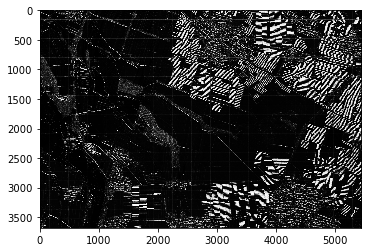

In [28]:
dapeng_train = cv2.imread("/root/MLCookbook/notebooks/dapeng/dapeng_train.png")
pred_x, _ = clip_into_peices(dapeng_train)
pred_y = trained_model.predict(pred_x)
num_of_row, num_of_col = dapeng_train.shape[0]/160, dapeng_train.shape[1]/160
result = stick_image(pred_y, 160, num_of_row, num_of_col)
plt.imshow(result, cmap="gray")

In [29]:
cv2.imwrite("result.png", result*255)

True

# 查看结果

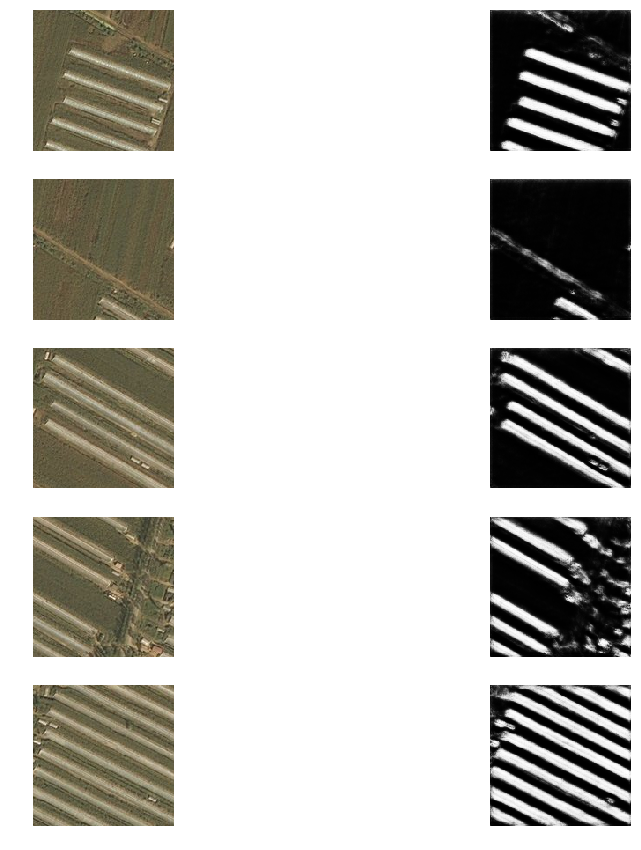

In [15]:
trained_model = get_unet(160)
trained_model.load_weights('weights/unet_best.hdf5')
pred_y = trained_model.predict(x_data[index][:5])
fig = plt.figure(figsize=(15,15))
for i in range(5):
    plt.subplot(5,2,i*2+1)
    plt.axis("off")
    plt.imshow(x_data[index][:5][i][:,:,::-1])
    plt.subplot(5,2,i*2+2)
    plt.axis("off")
    plt.imshow(pred_y[i].reshape(160,160), cmap="gray")

In [16]:
dapeng_train = cv2.imread("/root/MLCookbook/notebooks/dapeng/dapeng_train.png")
pred_x, _ = clip_into_peices(dapeng_train)
num_of_row, num_of_col = dapeng_train.shape[0]/160, dapeng_train.shape[1]/160

In [ ]:
y = trained_model.predict([pred_x[20][:,:,::-1]])

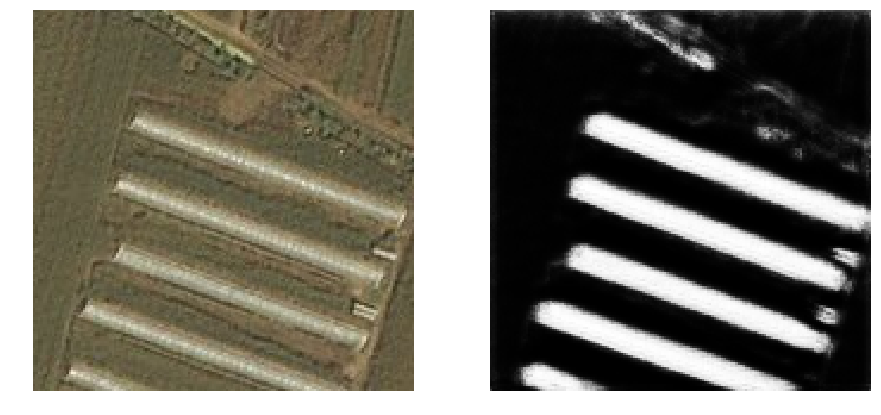

In [19]:
fig = plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.imshow(x_data[index][:5][0][:,:,::-1])
plt.subplot(1,2,2)
plt.axis("off")
plt.imshow(pred_y[0].reshape(160,160), cmap="gray")